In [1]:
from MClique import generate_clustered_network, perform_bond_percolation,remove_clusters, keep_clusters_with_node_swap, generate_clustered_network_discrete_M,perform_percolation
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
#from scipy.interpolate import interp1d

%matplotlib ipympl

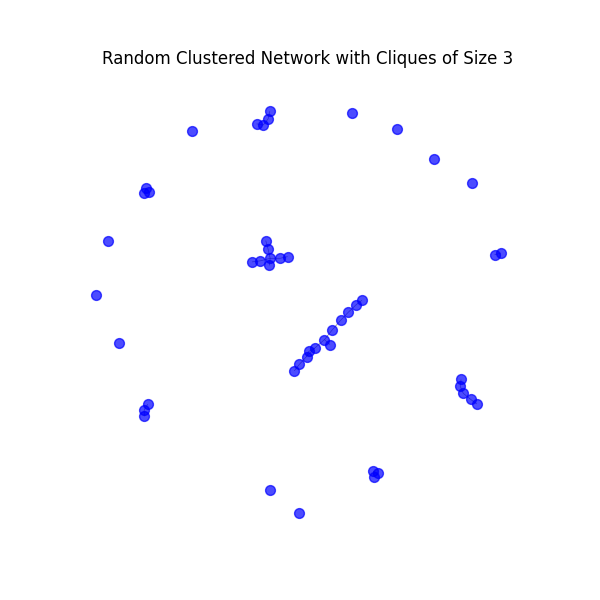

In [15]:
#An example of the network
N = 100   # Number of nodes in the network
M = 3 # Size of the cliques

# Generate the adjacency matrix
adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges= 1, m_cliques= 1)
adj_matrix = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = 0.5, H = 0.9)
# Create a NetworkX graph for visualization
G = nx.from_numpy_array(adj_matrix)

# Draw the network
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, iterations=100)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)

plt.axis('off')
plt.title(f'Random Clustered Network with Cliques of Size {M}')
plt.show()

100%|██████████| 10/10 [00:54<00:00,  5.48s/it]


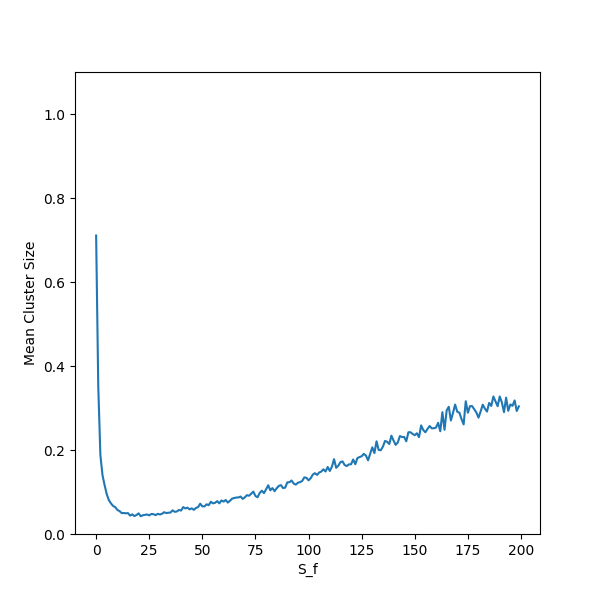

In [33]:
#Fixing clique size and edges, vary sf and plot mean percolation cluster size or mean final size, use p = 1 to characterize network and not disease

N = 500   # Number of nodes in the network
M = 3     # Size of the cliques
lambda_edge = 3

cluster_sizes = []
for i in tqdm(range(10)):
    k = 0
    # Generate the adjacency matrix
    adj_matrix, cliques, nr_cliques = generate_clustered_network_discrete_M(N, M, lambda_edges= lambda_edge, m_cliques= 2, nr_cliques = True)
    intermediate = []

    #print(nr_cliques)
    for sf in np.linspace(1/nr_cliques,1,200):
        adj_matrix_reduced = keep_clusters(adj_matrix, cliques, s_f = sf)

        percolation_clusters, percolation_giant = perform_percolation(adj_matrix_reduced, p = .6, N_p = 10)

        intermediate.append(percolation_clusters)        
    cluster_sizes.append(intermediate)


plt.figure(figsize= (6,6))

plt.plot(np.mean(cluster_sizes, axis = 0))
plt.ylim(0,1.1)
plt.xlabel("S_f")
plt.ylabel("Mean Cluster Size")
plt.show()


Nr. Runs Loop: 100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


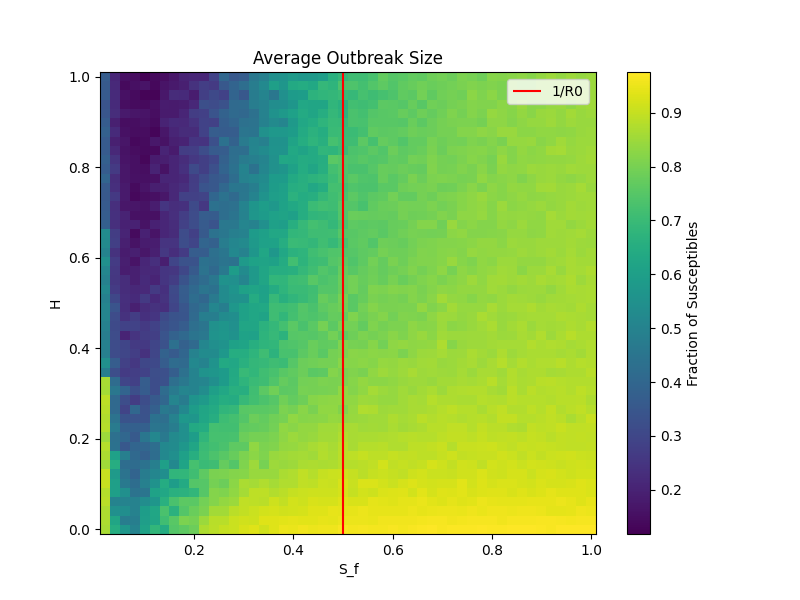

In [21]:
# """
# Now simulate varying both sf (0 to 1) and labmda_edges, recording the mean cluster size and giant component
# """

N = 100  # Number of nodes in the network
M = 3     # Size of the cliques

R0 = 2

p = R0/(R0+1)

N_H = 50
N_sf =  50

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 1, N_sf+1)[1:] #Eliminates the empty configuration

cluster_sizes = np.zeros((N_H, N_sf))
giant_component = np.zeros_like(cluster_sizes)

N_runs = 20

for _ in tqdm(range(N_runs), desc = "Nr. Runs Loop"):
    # Generate the adjacency matrix
    #adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2)
    adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges = 2, lambda_cliques = 2)
    for i, H_s in enumerate(H_values):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            percolation_clusters, _,  percolation_giant = perform_percolation(adj_matrix_reduced, p = p, N_p = 10)

            cluster_sizes[i,j] += percolation_clusters/N_runs    
            giant_component[i,j] += percolation_giant/N_runs       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, giant_component)
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

Perc. Param. Loop: 100%|██████████| 20/20 [05:08<00:00, 15.40s/it]


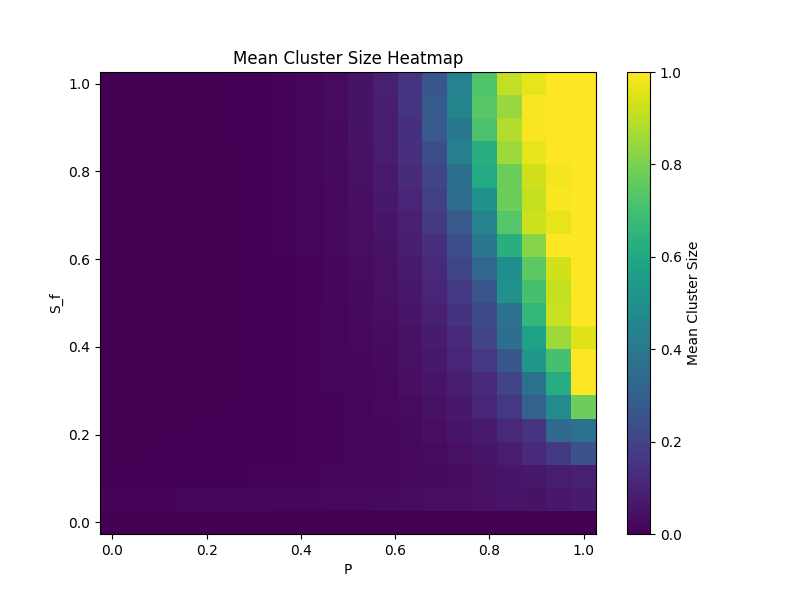

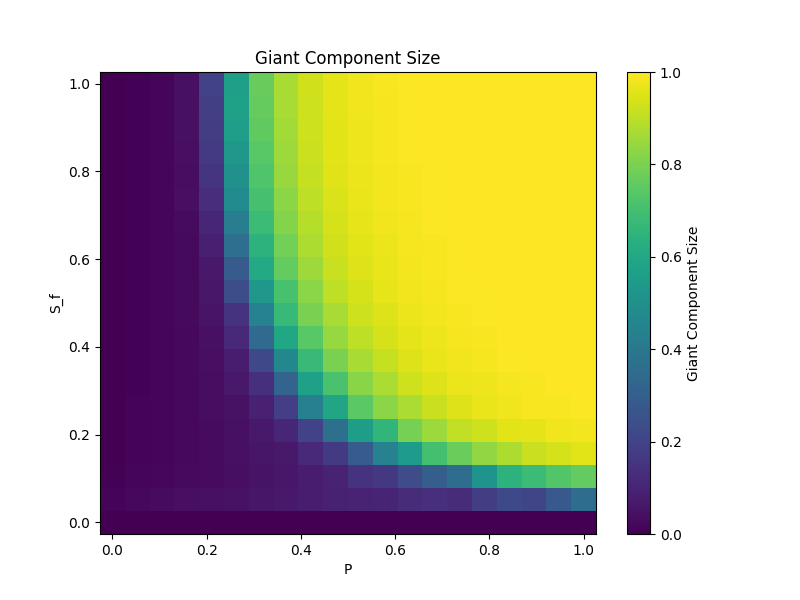

In [36]:
"""
Now simulate varying both sf (0 to 1) and percolation parameter (0,1), recording the mean cluster size and giant component
"""

N = 1000   # Number of nodes in the network
M = 3    # Size of the cliques

N_perc= 20
N_sf =  20


p_values = np.linspace(0, 1, N_perc)
sf_values = np.linspace(0, 1, N_sf)

cluster_sizes = np.zeros((N_sf, N_perc))
giant_component = np.zeros_like(cluster_sizes)
for i, p_vals in tqdm(enumerate(p_values), total=N_perc, desc="Perc. Param. Loop"):
    clusters = []
    giant_comp = []
    for _ in range(10):
        # Generate the adjacency matrix
        adj_matrix, cliques, nr_cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2, nr_cliques = True)
        intermediate_cluster = []
        intermediate_giant = []
        #print(nr_cliques)
        for sf in sf_values:
            adj_matrix_reduced = keep_clusters(adj_matrix, cliques, s_f = sf)

            percolation_clusters, percolation_giant = perform_percolation(adj_matrix_reduced, p = p_vals, N_p = 10)

            intermediate_cluster.append(percolation_clusters)        
            intermediate_giant.append(percolation_giant)        
        clusters.append(intermediate_cluster)
        giant_comp.append(intermediate_giant)
    cluster_sizes[: , i] = np.mean(clusters,axis = 0)
    giant_component[: , i] = np.mean(giant_comp,axis = 0)

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(p_values, sf_values)
plt.pcolormesh(X, Y, cluster_sizes)
plt.colorbar(label='Mean Cluster Size')
plt.xlabel("P")
plt.ylabel("S_f")
plt.title("Mean Cluster Size Heatmap")
plt.show()

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(p_values, sf_values)
plt.pcolormesh(X, Y, giant_component)
plt.colorbar(label='Giant Component Size')
plt.xlabel("P")
plt.ylabel("S_f")
plt.title("Giant Component Size")
plt.show()

Percolation Progress: 100%|██████████| 101/101 [00:43<00:00,  2.31it/s]


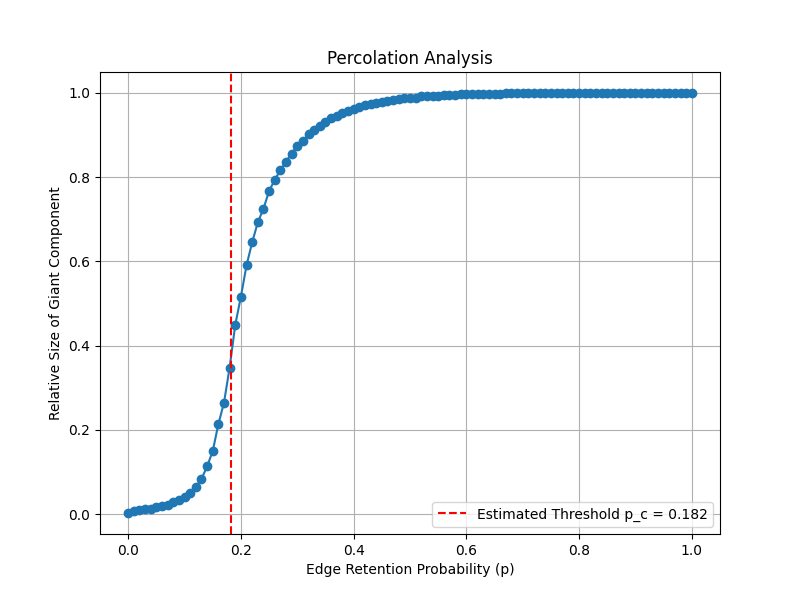

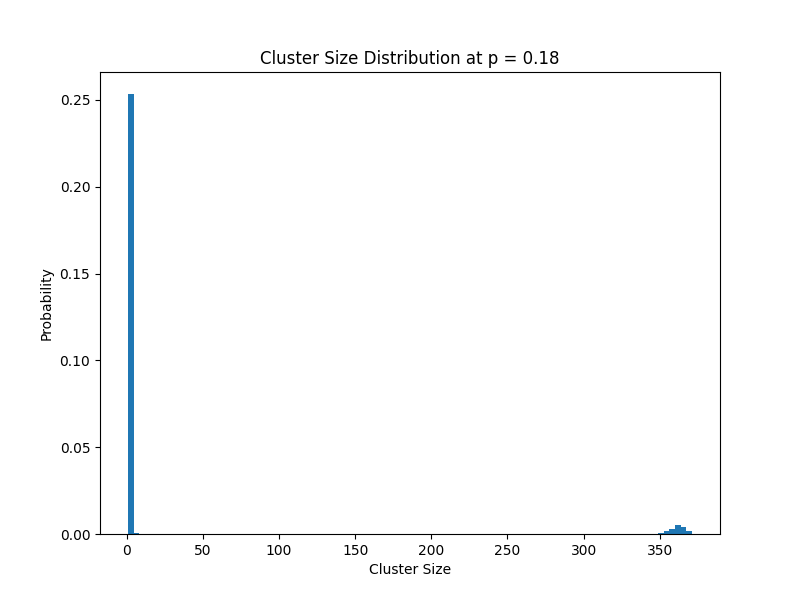

In [10]:
# Assume adj_matrix is obtained from the previous function generate_clustered_network
N = 500
M = 3
adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges= 2, m_cliques= 4)
adj_matrix = keep_clusters_with_node_swap(adj_matrix=adj_matrix, cliques=cliques, s_f=0.3, H = 0.2)

# Define percolation parameters
N_p = 200  # Number of trials per p
p_values = np.linspace(0.0, 1.0, 101)  # Edge retention probabilities from 0 to 1

# Perform bond percolation
percolation_results = perform_bond_percolation(adj_matrix, N_p, p_values)

# Plot the size of the giant component vs. p
plt.figure(figsize=(8, 6))
plt.plot(percolation_results['p_values'], percolation_results['giant_component_sizes'], marker='o')
plt.axvline(percolation_results['percolation_threshold'], color='r', linestyle='--', label=f'Estimated Threshold p_c = {percolation_results["percolation_threshold"]:.3f}')
plt.title('Percolation Analysis')
plt.xlabel('Edge Retention Probability (p)')
plt.ylabel('Relative Size of Giant Component')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the cluster size distribution at the percolation threshold
p_c_index = np.argmin(np.abs(percolation_results['p_values'] - percolation_results['percolation_threshold']))
cluster_sizes_at_pc = percolation_results['cluster_size_distributions'][p_c_index+20]

plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes_at_pc, bins = 100, density=True)
plt.title(f'Cluster Size Distribution at p = {percolation_results["p_values"][p_c_index]:.2f}')
plt.xlabel('Cluster Size')
plt.ylabel('Probability')
plt.show()


# What to ask now
- Can we produce the same analytical results as in Miller and Newman papers?
- How do we conduct the vaccination scheme (so how does clustering change outbreak prop - what fraction are in large cluster sizes/outbraks)?
    - This could involve picking uniformly to clusters in some way, and vaccinating/not vaccinating whole cliques, effectivly removing them from the graph
- As the mean number of M-cliques pr. nodes changes, how does the percolation parameter do so?
- Uniformly remove s nodes, vary "cliqueness" and record average outbreaksize.
- We should simulate results with cliques against simualtions with the same total degree without cliques



Remember we are assuming memmory-less (Markov property) and exponetially distributed waiting times to use $p_{infect} = \beta/(\beta+\nu)$

we should just jsut require self loops and isolated nodes to be discarded.